In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme(palette=sns.color_palette('Set2'))
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 150

## data import

In [3]:
# frame = pd.read_csv('..//1_web_scraping//apartment_details.csv')

In [4]:
query = '''
    select * from apt_details_raw
    where date = (select max(date) from apt_details_raw)
    '''

username = 'piotr'
password = os.environ['MYSQL_PASSWORD']
host = 'localhost'
db_name = 'airflow_db'
db_url = f'mysql+mysqlconnector://{username}:{password}@{host}/{db_name}'

engine = create_engine(db_url)

with engine.connect() as conn:
    frame = pd.read_sql_query(sql=query, con=conn, index_col='id')

frame.drop(['date'], axis=1, inplace=True)

for column in ['localization_y','localization_x','area','build_yr']:
    frame[column] = frame[column].astype('float')

In [5]:
frame.shape

(93414, 14)

In [6]:
frame.head()

,city,district,voivodeship,localization_y,localization_x,market,offer_type,area,rooms,floor,floors,build_yr,price,url
id,,,,,,,,,,,,,,
745541,Zabrze,Centrum,śląskie,50.310159,18.782158,pierwotny,sprzedaz,65.37,4,3,4,2025.0,Zapytajoce,https://gratka.pl/nieruchomosci/mieszkanie-zabrze-centrum-roberta-kozlika/ob/35346055
745542,Poznań,Strzeszyn,wielkopolskie,52.443089,16.873670,pierwotny,sprzedaz,35.12,1,3,3,2023.0,340567,https://gratka.pl/nieruchomosci/mieszkanie-poznan-strzeszyn-literacka/ob/29748901
745543,Chorzów,None,śląskie,50.286577,18.936671,pierwotny,sprzedaz,49.56,3,parter,None,2025.0,Zapytajoce,https://gratka.pl/nieruchomosci/mieszkanie-chorzow-odlegla/ob/30991661
745544,Wrocław,Krzyki,dolnośląskie,51.094496,17.028210,wtorny,sprzedaz,54.00,3,9,10,1973.0,639000,https://gratka.pl/nieruchomosci/mieszkanie-wroclaw-krzyki-sanocka/ob/37042799
745545,Lublin,Dziesiąta,lubelskie,51.216284,22.577453,wtorny,sprzedaz,205.00,7,1,2,2010.0,1499000,https://gratka.pl/nieruchomosci/mieszkanie-lublin-dziesiata/ob/31917307


In [7]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93414 entries, 745541 to 838954
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            93316 non-null  object 
 1   district        63307 non-null  object 
 2   voivodeship     93316 non-null  object 
 3   localization_y  93379 non-null  float64
 4   localization_x  93379 non-null  float64
 5   market          93331 non-null  object 
 6   offer_type      93414 non-null  object 
 7   area            93331 non-null  float64
 8   rooms           93100 non-null  object 
 9   floor           92410 non-null  object 
 10  floors          80139 non-null  object 
 11  build_yr        80322 non-null  float64
 12  price           93414 non-null  object 
 13  url             93414 non-null  object 
dtypes: float64(4), object(10)
memory usage: 10.7+ MB


In [8]:
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
localization_y,93379.0,51.915886,1.434228,49.276875,50.751550,52.128627,52.606460,54.833530
localization_x,93379.0,19.085460,1.827806,14.224291,17.956817,19.092900,20.880895,23.892034
area,93331.0,57.118243,25.707333,1.000000,41.090000,52.200000,66.000000,500.000000
build_yr,80322.0,2007.273449,31.262414,1200.000000,2001.000000,2023.000000,2025.000000,2032.000000


In [9]:
len(frame) == len(frame.drop_duplicates())

True

In [10]:
frame.offer_type.value_counts(normalize=True)

offer_type
sprzedaz    0.999807
wynajem     0.000193
Name: proportion, dtype: float64

In [11]:
frame.drop(frame[frame.offer_type=='wynajem'].index, inplace=True)

## renaming market type

In [12]:
frame.market.value_counts()

market
pierwotny    46855
wtorny       46458
Name: count, dtype: int64

In [13]:
frame.market.replace(['pierwotny','wtorny'], ['primary_market','aftermarket'], inplace=True)

## removing foreign locations

In [14]:
frame.voivodeship.value_counts()

voivodeship
mazowieckie            19749
pomorskie              11721
małopolskie            11586
dolnośląskie           10944
śląskie                 9860
wielkopolskie           6619
łódzkie                 5374
kujawsko-pomorskie      4319
zachodniopomorskie      3992
warmińsko-mazurskie     2096
lubelskie               1951
świętokrzyskie          1448
podkarpackie            1430
lubuskie                 798
opolskie                 713
podlaskie                565
zagranica                133
Name: count, dtype: int64

In [15]:
len(frame[frame.voivodeship=='zagranica'])/len(frame)

0.0014240438562679344

In [16]:
frame.drop(frame[frame.voivodeship=='zagranica'].index, inplace=True)

In [17]:
frame.shape

(93263, 14)

## removing data with no price

In [18]:
frame.price.value_counts(normalize=True).loc['Zapytajoce']

0.2478045956059745

In [19]:
frame.drop(index=frame[frame.price=='Zapytajoce'].index, axis=0, inplace=True)

In [20]:
frame.price = frame.price.astype('float')

In [21]:
frame.shape

(70152, 14)

## checking the amount of missing data and removing rows with small amount of missing data per column

In [22]:
num_desc = frame.describe().T
num_desc['%missing'] = (1-num_desc['count']/len(frame))*100
num_desc

,count,mean,std,min,25%,50%,75%,max,%missing
localization_y,70118.0,51.926604,1.462897,49.276875,50.589362,52.148850,53.083211,5.483353e+01,0.048466
localization_x,70118.0,19.031041,1.849191,14.224291,17.951108,19.041398,20.652902,2.389203e+01,0.048466
area,70069.0,58.651413,27.150834,1.000000,42.200000,53.160000,67.580000,5.000000e+02,0.118315
build_yr,57200.0,2000.196416,34.606111,1200.000000,1980.000000,2018.000000,2024.000000,2.032000e+03,18.462767
price,70152.0,717293.454328,577870.897179,0.000000,419000.000000,599900.000000,839000.000000,2.500000e+07,0.000000


In [23]:
obj_desc = frame.describe(include=['object']).T
obj_desc['%missing'] = (1-obj_desc['count']/len(frame))*100
obj_desc

,count,unique,top,freq,%missing
city,70056,1060,Warszawa,11181,0.136846
district,45040,598,Śródmieście,4511,35.796556
voivodeship,70056,16,mazowieckie,13794,0.136846
market,70069,2,aftermarket,46331,0.118315
offer_type,70152,1,sprzedaz,70152,0.0
rooms,69850,29,2,27366,0.430494
floor,69292,40,1,16411,1.225909
floors,64971,41,4,17938,7.385392
url,70152,70152,https://gratka.pl/nieruchomosci/mieszkanie-poznan-strzeszyn-literacka/ob/29748901,1,0.0


In [24]:
frame.dropna(subset=['price','localization_y','localization_x','area'], axis=0, inplace=True)

In [25]:
frame.dropna(subset=['market','offer_type','rooms','floor'], axis=0, inplace=True)

In [26]:
frame.shape

(69265, 14)

## dealing with missing data for 'floors', 'district', 'build_yr'

In [27]:
frame.dropna(subset=['build_yr'], axis=0, inplace=True)

In [28]:
len(frame[pd.isnull(frame.floors)])/len(frame)

0.050599693548671165

In [29]:
frame.dropna(subset=['floors'], axis=0, inplace=True)

In [30]:
# district will be left with missing data

In [31]:
frame.shape

(53906, 14)

## checking categorical data

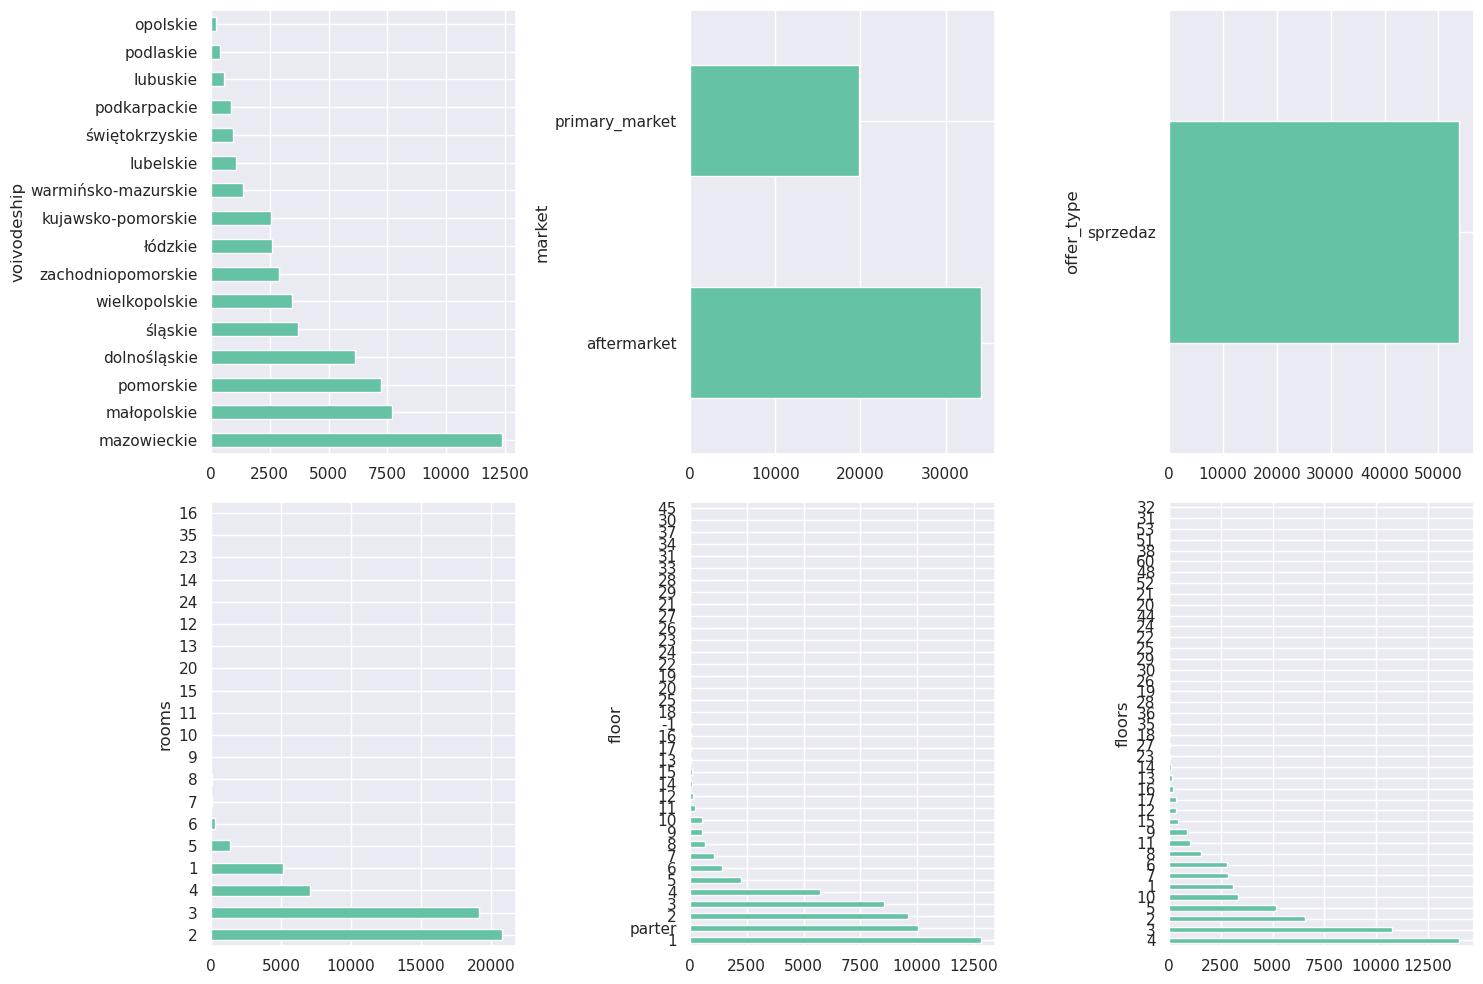

In [32]:
fig, axList = plt.subplots(nrows=2, ncols=3)
axList = axList.flatten()
fig.set_size_inches(15,10)

catagorical_columns = [x for x in frame.columns if frame[x].dtype == 'object' and x not in ['city','district','url']]

for ax, column in zip(axList, catagorical_columns):
    frame[column].value_counts().plot(kind='barh', ax=ax, ylabel=column)
    
plt.tight_layout()

In [33]:
frame.rooms = frame.rooms.astype('int')

In [34]:
len(frame[frame.rooms>8])/len(frame)

0.0007234816161466256

In [35]:
frame.floor.replace('parter', '0', inplace=True)
frame.floor = frame.floor.astype('int')

In [36]:
len(frame[frame.floor>15])/len(frame)

0.003543204838051423

In [37]:
frame.floors = frame.floors.astype('int')

In [38]:
len(frame[frame.floors>15])/len(frame)

0.017103847438133046

In [39]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53906 entries, 745542 to 838953
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            53903 non-null  object 
 1   district        36743 non-null  object 
 2   voivodeship     53903 non-null  object 
 3   localization_y  53906 non-null  float64
 4   localization_x  53906 non-null  float64
 5   market          53906 non-null  object 
 6   offer_type      53906 non-null  object 
 7   area            53906 non-null  float64
 8   rooms           53906 non-null  int64  
 9   floor           53906 non-null  int64  
 10  floors          53906 non-null  int64  
 11  build_yr        53906 non-null  float64
 12  price           53906 non-null  float64
 13  url             53906 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 6.2+ MB


In [40]:
frame.shape

(53906, 14)

## adding custom column

In [41]:
frame['price_of_sqm'] = frame.price / frame.area

## dealing with outliers

In [42]:
# checking quantile values

outliers_dict = dict()

for column in ['area','build_yr','price','price_of_sqm']:
    upper_quartile = np.nanpercentile(frame[column], 99.0)
    lower_quartile = np.nanpercentile(frame[column], 1.0)
#     iqr = upper_quartile - lower_quartile
#     outliers_dict[column] = (lower_quartile-1.5*iqr, upper_quartile+1.5*iqr)
    outliers_dict[column] = (lower_quartile, upper_quartile)

outliers_dict

{'area': (22.83, 154.20749999999987),
 'build_yr': (1900.0, 2026.0),
 'price': (185000.0, 2999000.0),
 'price_of_sqm': (3530.621917013251, 30650.944821267796)}

In [43]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,53906.0,58.932445,26.987661,9.030000,42.38,53.600000,68.000000,490.1
build_yr,53906.0,1999.439135,34.684420,1200.000000,1980.00,2017.000000,2024.000000,2032.0
price,53906.0,770406.766093,571877.926251,4540.000000,465000.00,649000.000000,880933.750000,16500000.0
price_of_sqm,53906.0,13265.091741,6046.892953,103.181818,9000.00,12390.972221,16509.485655,279960.0


In [44]:
outliers_dict['build_yr'] = (1900.0, 2024.0)

In [45]:
for key in outliers_dict.keys():
    frame.drop(frame[frame[key] < outliers_dict[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict[key][1]].index, inplace = True)

In [46]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,42142.0,58.286025,21.799758,22.86000,43.500000,54.000000,67.91,1.541600e+02
build_yr,42142.0,1996.239690,31.338932,1900.00000,1975.000000,2010.000000,2023.00,2.024000e+03
price,42142.0,741941.450121,405981.334358,185000.00000,474000.000000,654000.000000,885000.00,2.999000e+06
price_of_sqm,42142.0,13046.402908,5337.826790,3532.00883,8882.078919,12315.068493,16500.00,3.063209e+04


In [47]:
len(frame[frame.floor>15]), len(frame[frame.floors>15])

(120, 668)

In [48]:
frame.drop(frame[frame.floor>15].index, axis=0, inplace=True)
frame.drop(frame[frame.floors>15].index, axis=0, inplace=True)

In [49]:
len(frame[frame.rooms>6])

50

In [50]:
frame.drop(frame[frame.rooms>6].index, axis=0, inplace=True)

In [51]:
frame.shape

(41424, 15)

## dealing with outliers in localization

In [52]:
frame.localization_x.min(), frame.localization_x.max()

(14.22429085, 23.6725471)

In [53]:
frame.localization_y.min(), frame.localization_y.max()

(49.27687469, 54.83353)

In [54]:
outliers_dict_2 = dict()
outliers_dict_2['localization_x'] = (14,25)
outliers_dict_2['localization_y'] = (48,55)

In [55]:
for key in outliers_dict_2.keys():
    frame.drop(frame[frame[key] < outliers_dict_2[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict_2[key][1]].index, inplace = True)

In [56]:
len(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)])

0

In [57]:
frame.drop(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)].index,inplace=True)

In [58]:
frame.shape

(41424, 15)

## checking histograms

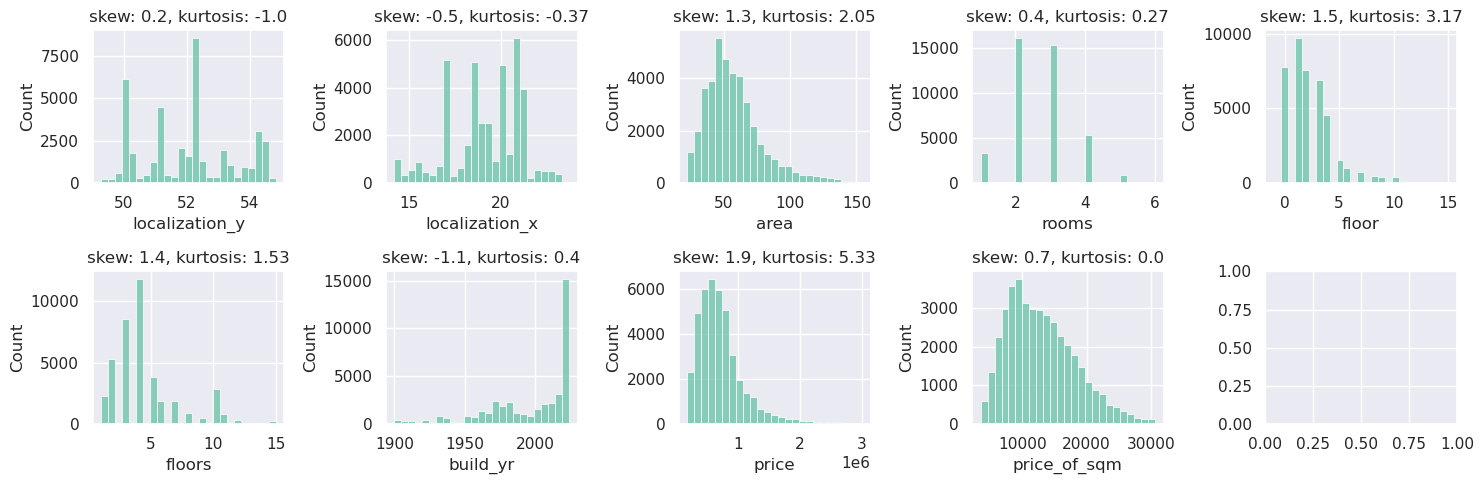

In [59]:
fig, axList = plt.subplots(nrows=2, ncols=5)
axList = axList.flatten()
fig.set_size_inches(15,5)

numeric_columns = [x for x in frame.columns if frame[x].dtype in ['float64','int64']]
kurtosis_dict = dict(frame[numeric_columns].kurtosis())

for ax, column in zip(axList, numeric_columns):
    sns.histplot(frame, x=frame[column], ax=ax, bins=25)
    ax.title.set_text(f'skew: {round(frame[column].skew(), 1)}, kurtosis: {round(kurtosis_dict[column], 2)}')
    
plt.tight_layout()

## data summary

In [60]:
round(frame.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
localization_y,41424.0,52.02,1.46,49.28,50.89,52.19,53.12,54.83
localization_x,41424.0,19.14,1.92,14.22,18.00,19.42,20.93,23.67
area,41424.0,58.23,21.70,22.86,43.41,54.00,67.84,154.16
rooms,41424.0,2.63,0.91,1.00,2.00,3.00,3.00,6.00
floor,41424.0,2.36,2.20,-1.00,1.00,2.00,3.00,15.00
floors,41424.0,4.57,2.71,1.00,3.00,4.00,5.00,15.00
build_yr,41424.0,1996.01,31.43,1900.00,1975.00,2009.00,2023.00,2024.00
price,41424.0,736516.26,402485.81,185000.00,470000.00,650000.00,877126.75,2999000.00
price_of_sqm,41424.0,12964.51,5300.04,3532.01,8840.90,12218.17,16379.31,30632.09


In [61]:
frame.describe(include=['object']).T

,count,unique,top,freq
city,41421,737,Warszawa,8049
district,27961,539,Śródmieście,2506
voivodeship,41421,16,mazowieckie,9806
market,41424,2,aftermarket,30966
offer_type,41424,1,sprzedaz,41424
url,41424,41424,https://gratka.pl/nieruchomosci/mieszkanie-poznan-strzeszyn-literacka/ob/29748901,1


In [62]:
frame.reset_index(drop=True, inplace=True)

In [63]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41424 entries, 0 to 41423
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            41421 non-null  object 
 1   district        27961 non-null  object 
 2   voivodeship     41421 non-null  object 
 3   localization_y  41424 non-null  float64
 4   localization_x  41424 non-null  float64
 5   market          41424 non-null  object 
 6   offer_type      41424 non-null  object 
 7   area            41424 non-null  float64
 8   rooms           41424 non-null  int64  
 9   floor           41424 non-null  int64  
 10  floors          41424 non-null  int64  
 11  build_yr        41424 non-null  float64
 12  price           41424 non-null  float64
 13  url             41424 non-null  object 
 14  price_of_sqm    41424 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 4.7+ MB


## saving the frame

In [64]:
# outfile = open('apartment_data_frame','wb')
# pkl.dump(frame, outfile)
# outfile.close()